In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('spx.csv', parse_dates=['date'], index_col = 'date')

In [3]:
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97



Bad key "text.kerning_factor" on line 4 in
C:\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


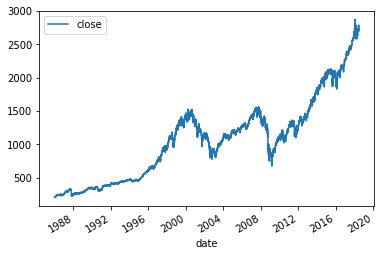

In [4]:
df.plot()

In [5]:
train_size = int(len(df)*0.95)

In [6]:
test_size = len(df) - train_size

In [7]:
train_size

7782

In [8]:
test_size

410

In [9]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]

In [10]:
print(train.shape, test.shape)

(7782, 1) (410, 1)


In [11]:
from sklearn.preprocessing import StandardScaler

In [12]:
scaler = StandardScaler()

In [13]:
scaler = scaler.fit(train[['close']])

In [14]:
scaler

StandardScaler()

In [15]:
train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

C:\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


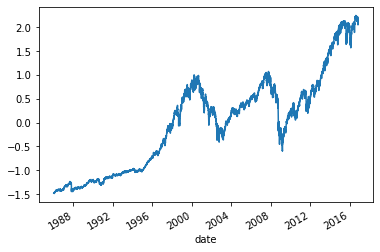

In [17]:
train['close'].plot()

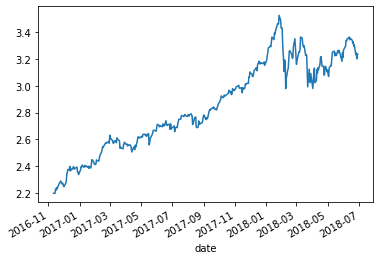

In [18]:
test['close'].plot()

In [19]:
def create_dataset(X, y, time_steps=1):
    
    Xs, ys = [], []
    
    for i in range(len(X)-time_steps):
        
        v = X.iloc[i:(i + time_steps)].values
        
        Xs.append(v)
        ys.append(y.iloc[i+time_steps])
        
    return np.array(Xs), np.array(ys)        

In [20]:
TIME_STEPS = 30

In [21]:
X_train, y_train = create_dataset(train[['close']],
                                  train.close,
                                  TIME_STEPS
                                 )

In [22]:
train[['close']]

,close
date,
1986-01-02,-1.475126
1986-01-03,-1.472703
1986-01-06,-1.473135
1986-01-07,-1.467219
1986-01-08,-1.478169
...,...
2016-11-04,2.047774
2016-11-07,2.134814
2016-11-08,2.149916


In [23]:
train['close']

date
1986-01-02   -1.475126
1986-01-03   -1.472703
1986-01-06   -1.473135
1986-01-07   -1.467219
1986-01-08   -1.478169
                ...   
2016-11-04    2.047774
2016-11-07    2.134814
2016-11-08    2.149916
2016-11-09    2.194431
2016-11-10    2.202357
Name: close, Length: 7782, dtype: float64

In [24]:
X_test, y_test = create_dataset(
  test[['close']],
  test.close,
  TIME_STEPS
)

In [31]:
print(X_train.shape)

(7752, 30, 1)


In [36]:
from keras.models import Sequential, Model

In [52]:
from keras.layers import Dense, LSTM, Input, Dropout, RepeatVector, TimeDistributed

In [75]:
model = Sequential()

In [76]:
model.add(LSTM(units = 64,
              input_shape = (X_train.shape[1], X_train.shape[2])))

In [77]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                16896     
Total params: 16,896
Trainable params: 16,896
Non-trainable params: 0
_________________________________________________________________


In [78]:
model.add(Dropout(rate=0.2))

In [79]:
model.add(RepeatVector(n = X_train.shape[1]))

In [80]:
model.add(LSTM(units=64, return_sequences = True))

In [81]:
model.add(Dropout(rate=0.2))

In [82]:
model.add(TimeDistributed(Dense(units = X_train.shape[2])))

In [83]:
model.compile(loss='mae', optimizer='adam')

In [84]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                16896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 30, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30, 64)            33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 64)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 1)             65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
__________________________________________________

In [85]:
history = model.fit(X_train, y_train,
                   epochs = 10,
                   batch_size = 32,
                   validation_split = 0.1,
                   shuffle=False)

Epoch 1/10
218/218 [==============================] - 5s 21ms/step - loss: 0.1759 - val_loss: 0.2153
Epoch 2/10
218/218 [==============================] - 3s 16ms/step - loss: 0.0924 - val_loss: 0.1780
Epoch 3/10
218/218 [==============================] - 3s 14ms/step - loss: 0.0962 - val_loss: 0.0878
Epoch 4/10
218/218 [==============================] - 4s 16ms/step - loss: 0.1084 - val_loss: 0.0761
Epoch 5/10
218/218 [==============================] - 3s 14ms/step - loss: 0.1309 - val_loss: 0.1222
Epoch 6/10
218/218 [==============================] - 3s 15ms/step - loss: 0.1232 - val_loss: 0.1463
Epoch 7/10
218/218 [==============================] - 3s 12ms/step - loss: 0.1244 - val_loss: 0.0919
Epoch 8/10
218/218 [==============================] - 3s 13ms/step - loss: 0.1133 - val_loss: 0.0770
Epoch 9/10
218/218 [==============================] - 3s 12ms/step - loss: 0.1097 - val_loss: 0.0827
Epoch 10/10
218/218 [==============================] - 3s 15ms/step - loss: 0.1066 - val_lo

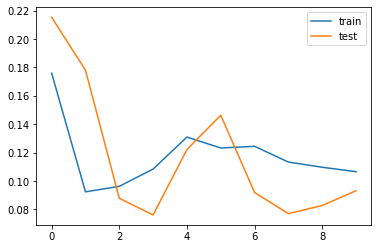

In [116]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

In [86]:
X_train_pred = model.predict(X_train)

In [87]:
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis = 1)

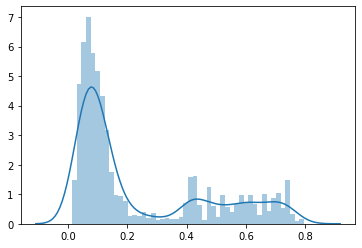

In [120]:
sns.distplot(train_mae_loss, bins=50, kde = True)

In [99]:
THRESHOLD = 0.45

In [100]:
X_test_pred = model.predict(X_test)

In [101]:
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis = 1)

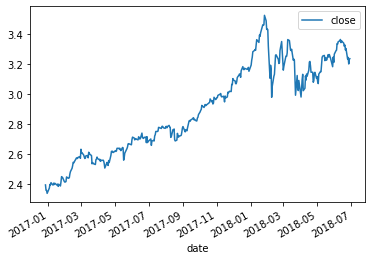

In [102]:
test[TIME_STEPS:].plot()

In [103]:
test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)

In [104]:
test_score_df['loss'] = test_mae_loss

In [105]:
test_score_df['threshold'] = THRESHOLD

In [106]:
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold

In [107]:
test_score_df['close'] = test[TIME_STEPS:].close

In [108]:
test_score_df

,loss,threshold,anomaly,close
date,,,,
2016-12-27,0.119550,0.45,False,2.392816
2016-12-28,0.120321,0.45,False,2.357204
2016-12-29,0.124901,0.45,False,2.355964
2016-12-30,0.129221,0.45,False,2.336373
2017-01-03,0.140060,0.45,False,2.372061
...,...,...,...,...
2018-06-25,0.266493,0.45,False,3.234646
2018-06-26,0.292931,0.45,False,3.245897
2018-06-27,0.304654,0.45,False,3.201889


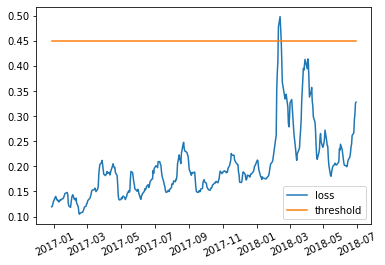

In [121]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

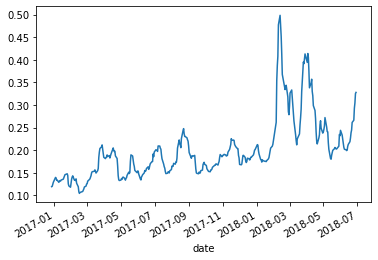

In [109]:
test_score_df['loss'].plot()

In [110]:
anomalies = test_score_df[test_score_df.anomaly == True]

In [111]:
anomalies

,loss,threshold,anomaly,close
date,,,,
2018-02-09,0.477426,0.45,True,3.051476
2018-02-12,0.498419,0.45,True,3.119939
2018-02-13,0.475465,0.45,True,3.132975
2018-02-14,0.451720,0.45,True,3.200011


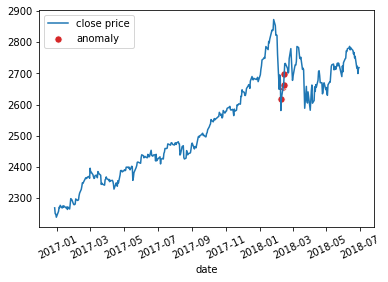

In [122]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();